This dataset consists of a survey of 649 students taking their portugese class in Portugal. The author of the survey wanted to see if there is a link between certain criteria and school performance (http://www3.dsi.uminho.pt/pcortez/student.pdf). 

I will use this dataset to analyze probability of past class failures, based on final grade of the current portuguese class. We will be using Pymc3 for this. 

Thank you to Cam Davidson. Much of which is taken from: 
(nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)

In [54]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import theano.tensor as tt

%matplotlib inline

In [55]:
df = pd.read_csv("student-por.csv")

In [56]:
df['failed'] = 0
df.loc[df.failures>0, 'failed'] = 1 # if student had more than zero failures in the past, add 1 to total_fa. column

In [65]:
print("100 current students had failures in past classes")
df.failed.value_counts()

100 current students had failures in past classes


0    549
1    100
Name: failed, dtype: int64

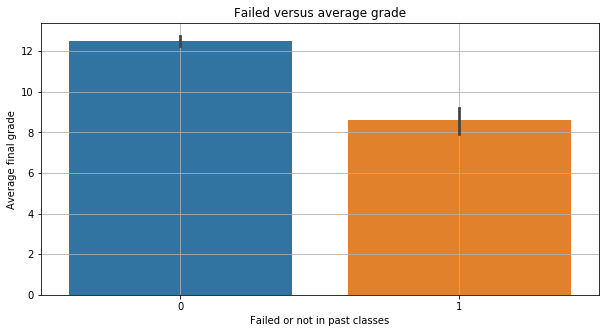

Apparently, for students that had past failures in other classes, their avg. final grade in portuguese class ~ 8.5


In [66]:
plt.figure(figsize=(10,5))
sns.barplot(df.failed, df.G3)
plt.title("Failed versus average grade")
plt.ylabel("Average final grade")
plt.xlabel("Failed or not in past classes")
plt.grid()
plt.show()
print("Apparently, for students that had past failures in other classes, their avg. final grade in portuguese class ~ 8.5")

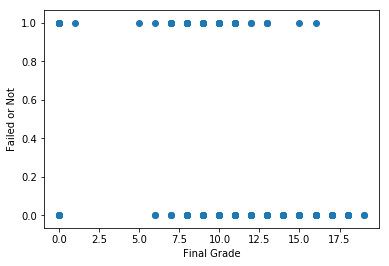

We can see that past failures in other classes (1) has some correlation with lower final grade in this portuguese class.


In [64]:
plt.scatter(df.G3, df.failed)
plt.ylabel("Failed or Not")
plt.xlabel("Final Grade")
plt.show()
print("We can see that past failures in other classes (1) has some correlation with lower final grade \
in this portuguese class.")

# Build the model

We will use pymc3 to calculate the probability that a student failed past classes, based on their final grade in Portuguese class. 

To do this, we need a function of final grade, call it p(fg), that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as grades increase. There are many such functions, but the most popular choice is the logistic function. 

`p(fg)= 1/ (1+e**((β*final_grade)+α))`

This function has two parameters: β,α. These parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a Normal random variable. For more information on these parameters, please see the "Challenger Space Shuttle Disaster", in: http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

In [67]:
final_grade = np.array(df.G3) # final grade
failed_past_classes = np.array(df.failed)  # failed past classes (1) or not (0)?

# We have to set the values of beta and alpha to 0. The reason for this is that if beta and alpha are very large, 
# they make p equal to 1 or 0. Unfortunately, pm.Bernoulli does not like probabilities of exactly 0 or 1, though 
# they are mathematically well-defined probabilities. So by setting the coefficient values to 0, we set the variable 
# p to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any 
# additional information in our prior. It is simply a computational caveat in PyMC3

with pm.Model() as model:
    # when τ=0.001 (precision), the variance is 1/τ (AKA, σ**2 or std**2), which is 1000
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)  
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp((beta*final_grade) + alpha))) # p(fg)= 1/ (1+e**((β*final_grade)+α))

Below is a sample of possible values for beta and alpha, based on the Normal distribution and the hyperparameters that we are using.

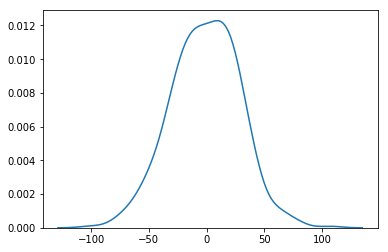

In [61]:
np.random.seed(seed=13)
norm = pm.Normal.dist(mu=0, sd=31.622).random(size=500)
sns.kdeplot(norm)
plt.show()

Now, we'll connect the probabilities in `p` with our observations through a Bernoulli random variable. A Bernoulli random variable with parameter p, denoted Ber(p), is a random variable that takes value 1 with probability p, and 0 else. Thus, our model can look like:

* Past Failures, PFi∼Ber(p(FINAL_GRADEi)), i=1..N

In [68]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=failed_past_classes)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -226.91, ||grad|| = 7.4321e-05: 100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 188.30it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
The number of effective samples is smaller than 10% for some parameters.


In [36]:
pm.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.441304,0.054580,0.004253,0.340338,0.552008,50.691143,1.027626
alpha,-3.081900,0.579252,0.044519,-4.242425,-1.987315,51.981617,1.027239
p__0,0.145976,0.016093,0.000326,0.116287,0.179457,2251.587032,1.000838
p__1,0.145976,0.016093,0.000326,0.116287,0.179457,2251.587032,1.000838
p__2,0.099359,0.013648,0.000586,0.072612,0.125547,224.157125,1.006607
p__3,0.044292,0.009829,0.000618,0.026234,0.063914,85.000869,1.015208
p__4,0.066641,0.011746,0.000658,0.044410,0.089890,109.910717,1.011998
p__5,0.066641,0.011746,0.000658,0.044410,0.089890,109.910717,1.011998
p__6,0.066641,0.011746,0.000658,0.044410,0.089890,109.910717,1.011998
p__7,0.066641,0.011746,0.000658,0.044410,0.089890,109.910717,1.011998


Above, we can see the average mean for alpha and beta, as well as the estimated probability of each student having failed past classes.  

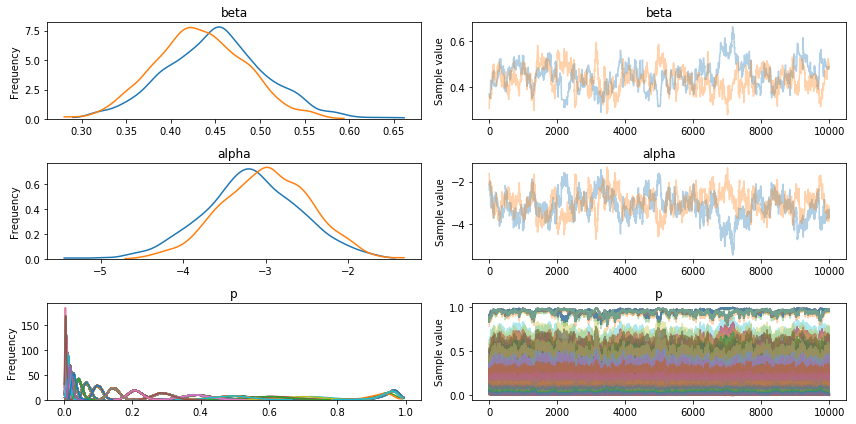

In [37]:
pm.traceplot(burned_trace)
plt.show()

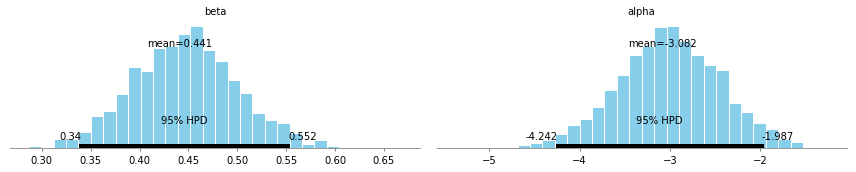

In [35]:
pm.plot_posterior(burned_trace,
                  varnames=['beta','alpha'], 
                  color='#87ceeb')
plt.show()

All samples of β are greater than 0. If instead the posterior was centered around 0, we may suspect that β=0, implying that the final grade has no effect on the probability of past failures.

Similarly, all α posterior values are negative and far away from 0, implying that it is correct to believe that α is significantly less than 0.

**Next, let's look at the expected value line and the associated 95% intervals for each final grade.** That is, we average over all samples from the posterior to get a likely value for p(FINAL_GRADEi). 

In [39]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha)) #same as (1.0/(1. + tt.exp(beta*final_grade + alpha)))

t = np.linspace(final_grade.min() - 1, final_grade.max()+1, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples) #t.T changes shape from (50,1) to (1,50)

mean_prob_t = p_t.mean(axis=0)

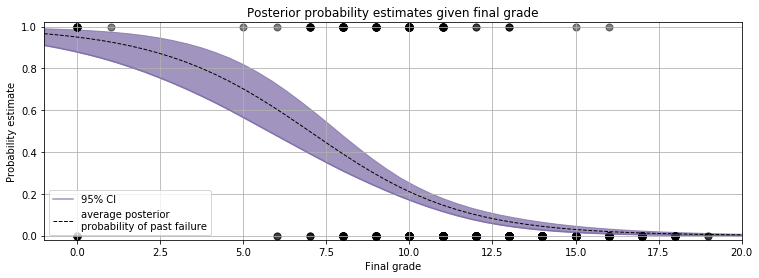

In [50]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(12.5, 4))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of past failure")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(final_grade, failed_past_classes, color="k", s=50, alpha=0.5)
plt.xlabel("Final grade")

plt.ylabel("Probability estimate")
plt.title("Posterior probability estimates given final grade")
plt.grid()
plt.show()

The 95% credible interval, or 95% CI, painted in purple, represents the interval, for each final grade, that contains 95% of the distribution. For example, at 10 final grade, we can be 95% sure that the probability of past failures in other classes lies between 0.18 and 0.25. At 5 final grade, the probability is between 0.58 and 0.82

More generally, we can see that as the final grades nears 6, the CI experiences a bigger probability spread. As we pass 10 final grade, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more students with final grades between 5.0 and 7.5 to get a better estimate of probabilities in that range.

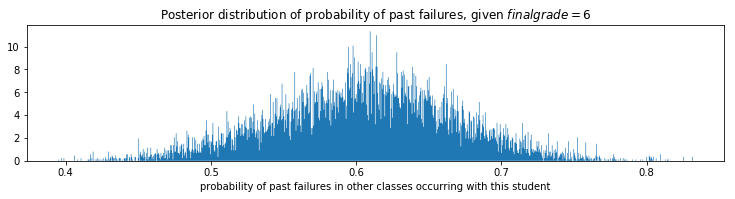

In [53]:
plt.figure(figsize=(12.5, 2.5))

prob_6 = logistic(6, beta_samples, alpha_samples)

# plt.xlim(0.995, 1) # expand this if need be
plt.hist(prob_6, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of past failures, given $final grade = 6$")
plt.xlabel("probability of past failures in other classes occurring with this student");

Above, we can check for probabilites of past failures, based on a particular final grade. For example, we see above that a student that received a final grade of 6 in current portuguese class, had a 0.5 to 0.7 probability of having failed past classes.